In [41]:
import requests
from requests.exceptions import HTTPError

import math
import pandas as pd
from decimal import Decimal
from pandas.io.json import json_normalize
import json

import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import truncnorm, norm

In [42]:
#Variables/Params
api_key = '46583da07984f6f5e5acc0442fad24656e164280da7811e9aefa8bcfc9d1' #defi pulse

In [43]:
#get json query
def defipulse_getdata(request, api_key):
    try:
        response = requests.get('https://data-api.defipulse.com/api/v1/defipulse/api/' + request +'?api-key=' + api_key + '&period=1y')
        response.raise_for_status()
        # access JSOn content
        return response.json()
        #print("Entire JSON response")
        #print(api_output[0]) #validate response from API

    except HTTPError as http_err:
        return (f'HTTP error occurred: {http_err}')
    except Exception as err:
        return (f'Other error occurred: {err}')

#convert to callable dataframe
def get_lendrates(data):
    df = pd.DataFrame.from_dict(data)
    data = pd.json_normalize(df['lend_rates'])
    data = pd.merge(pd.to_datetime(df['timestamp'],unit='s').dt.date, data, left_index=True, right_index=True)
    data = data.set_index('timestamp')
    return data

In [44]:
lendingdata = get_lendrates(defipulse_getdata('getLendingHistory',api_key))
brl = pdr.DataReader('DEXBZUS', 'fred')

Text(0.5, 0, 'Year')

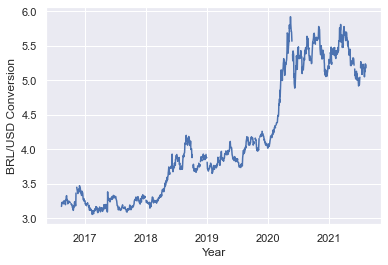

In [45]:
#normalise datetime and index by date
lendingdata.index.astype('datetime64[ns]')
brl.index.astype('datetime64[ns]')


#compute BRL daily change
brl_dailychange = brl.pct_change()
brl_dailychange

plt.figure(0)
plt.plot(brl)
plt.ylabel("BRL/USD Conversion")
plt.xlabel("Year")



In [46]:
dat = pd.DataFrame(lendingdata)
dat


,maker,compound,aave,dydx,c.r.e.a.m.-finance,definer
timestamp,,,,,,
2021-08-13,0.010007,2.036469,2.659849,3.045513,8.418867,2.879017
2021-08-12,0.010007,2.018869,2.617055,2.574433,8.529813,2.864959
2021-08-11,0.010007,2.009011,2.915110,2.484445,6.999971,2.800581
2021-08-10,0.010007,2.018198,2.562185,2.219472,7.655059,2.842799
2021-08-09,0.010007,1.941999,2.541320,1.638192,7.994740,2.768417
...,...,...,...,...,...,...
2020-08-18,0.000000,3.212895,NaN,4.683096,NaN,NaN
2020-08-17,0.000000,3.346527,NaN,7.990855,NaN,NaN
2020-08-16,0.000000,3.571247,NaN,5.830438,NaN,NaN


Chance of loss 90 period: 34.0%
Chance gain 90 period: 66.0%


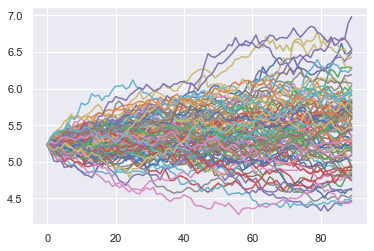

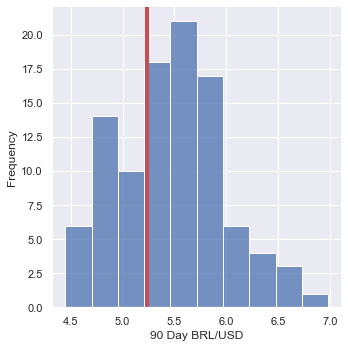

In [47]:
def monte(data,days,trials, apr): #if data is apr()
    #checks if input is dataframe, if not makes it into a dataframe
    data = pd.DataFrame(data)

    #if data is apr it will normalise it to annual, else if data is price it will calc the percentage change
    if apr ==  False:
        log_returns = np.log(1 + data.pct_change()) #calculated daily change
    
    elif True:
        data = data/365
        log_returns = np.log(1 + data)
    
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5*var)

    stdev = log_returns.std()
    Z = norm.ppf(np.random.rand(days, trials)) #days, trials
    daily_returns = np.exp(drift.values + stdev.values * Z)

    price_paths = np.zeros_like(daily_returns)
    price_paths[0] = data.iloc[-1]
    for t in range(1, days):
        price_paths[t] = price_paths[t-1]*daily_returns[t]
     #prep output into dataframe
    return pd.DataFrame(price_paths)

def joinmonte(df1,df2):
    simulation =  pd.DataFrame()
    for n in range(0,len(df1.columns)):
        simulation[n] = df1[n] + df2[n]
    return simulation

brl_monte = monte(brl,90,100, False)
lenddat_monte = monte(lendingdata['dydx'],90,100, True)
simulation = joinmonte(brl_monte, lenddat_monte)



#fig, (ax1, ax2) = plt.subplots(1, 2)
plt.plot(simulation)

#outcome histogram
sns.displot(simulation.iloc[(len(simulation)-1),:])
plt.xlabel(str(len(simulation)) + " Day BRL/USD")
plt.ylabel("Frequency")
plt.axvline(simulation.iloc[0,0],linewidth=4, color='r', label='starting price')

#num_simulations = int(len(simulation.columns()))
count_loss = ( sum(1 if x <= simulation.iloc[0,0] else 0 for x in simulation.iloc[(len(simulation)-1),:]) /100 )*100
count_gain = ( sum(1 if x > simulation.iloc[0,0] else 0 for x in simulation.iloc[(len(simulation)-1),:]) /100 )*100
print ("Chance of loss " + str(len(simulation)) + " period: " + str(count_loss) + "%")
print ("Chance gain " + str(len(simulation)) + " period: " + str(count_gain) + "%")

plt.tight_layout()


<AxesSubplot:xlabel='apy'>

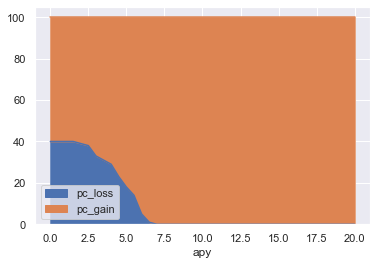

In [54]:


#BRL monte carlo Simulkator
#APY data generation (gaussian)
def generate_apy_gauss(value, stdev, var, days):
    lownum = value - var
    highnum = value + var
    def get_truncated_normal(mean, sd, low, upp):
        return truncnorm(
            (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    X = get_truncated_normal(mean=value, sd=2, low=lownum, upp=highnum)
    return pd.DataFrame(X.rvs(days))

def monte(data,days,trials, apr): #if data is apr()
    #checks if input is dataframe, if not makes it into a dataframe
    data = pd.DataFrame(data)

    #if data is apr it will normalise it to annual, else if data is price it will calc the percentage change
    if apr ==  False:
        log_returns = np.log(1 + data.pct_change()) #calculated daily change
    
    elif True:
        data = data/365
        log_returns = np.log(1 + data)
    
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5*var)

    stdev = log_returns.std()
    Z = norm.ppf(np.random.rand(days, trials)) #days, trials
    daily_returns = np.exp(drift.values + stdev.values * Z)

    price_paths = np.zeros_like(daily_returns)
    price_paths[0] = data.iloc[-1]
    for t in range(1, days):
        price_paths[t] = price_paths[t-1]*daily_returns[t]
     #prep output into dataframe
    return pd.DataFrame(price_paths)

def joinmonte(df1,df2):
    simulation =  pd.DataFrame()
    for n in range(0,len(df1.columns)):
        simulation[n] = df1[n] + df2[n]
    return simulation

def printoutcome(data):
    #outcome histogram
    sns.displot(data.iloc[(len(data)-1),:])
    plt.xlabel(str(len(data)) + " Day BRL/USD")
    plt.ylabel("Frequency")
    plt.axvline(data.iloc[0,0],linewidth=4, color='r', label='starting price')

    #num_data = int(len(data.columns()))
    count_loss = ( sum(1 if x <= data.iloc[0,0] else 0 for x in data.iloc[(len(data)-1),:]) /100 )*100
    count_gain = ( sum(1 if x > data.iloc[0,0] else 0 for x in data.iloc[(len(data)-1),:]) /100 )*100
    return count_loss, count_gain

apy_values = np.arange(0, 20.5, 0.5).tolist()

def generate_apysimdat(basedat, apyvals, stdev,var,days, trials):
    simoutput = pd.DataFrame(columns = ["apy", "pc_loss", "pc_gain"])
    basedat_monte = monte(basedat,days,trials, False)
    simoutput["apy"] = apyvals 
    for n in range(0, len(apyvals)):
        randapydat = generate_apy_gauss(n, stdev, var, days) #generate gaussian 
        randapydat_monte = monte(randapydat,days,trials, True) #generate montecarlo sim for apy
        simulation = joinmonte(basedat_monte, randapydat_monte)
        count_loss = ( sum(1 if x <= simulation.iloc[0,0] else 0 for x in simulation.iloc[(len(simulation)-1),:]) /100 )*100
        count_gain = ( sum(1 if x > simulation.iloc[0,0] else 0 for x in simulation.iloc[(len(simulation)-1),:]) /100 )*100
        simoutput.iloc[n,1] = count_loss
        simoutput.iloc[n,2] = count_gain
    return simoutput



generate_apysimdat(brl, apy_values,1,.5,90, 100)
simulation_data = generate_apysimdat(brl, apy_values,1,.5,90, 100)
simulation_data.plot.area(x = 'apy')